In [9]:
# example.py
import imageio
import gymnasium as gym
import numpy as np
import gym_aloha
import matplotlib.pyplot as plt
import logging
import os
import time
from dataclasses import asdict
from pprint import pformat
import draccus
import rerun as rr

from pathlib import Path

import lerobot

# from safetensors.torch import load_file, save_file
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.policies.factory import make_policy
from lerobot.common.robot_devices.control_configs import (
    CalibrateControlConfig,
    ControlConfig,
    ControlPipelineConfig,
    RecordControlConfig,
    RemoteRobotConfig,
    ReplayControlConfig,
    TeleoperateControlConfig,
)
from lerobot.common.robot_devices.control_utils import (
    control_loop,
    init_keyboard_listener,
    is_headless,
    log_control_info,
    record_episode,
    reset_environment,
    sanity_check_dataset_name,
    sanity_check_dataset_robot_compatibility,
    stop_recording,
    warmup_record,
)
from lerobot.common.robot_devices.robots.utils import Robot, make_robot_from_config
from lerobot.common.robot_devices.utils import busy_wait, safe_disconnect
from lerobot.common.utils.utils import has_method, init_logging, log_say
from lerobot.configs import parser

In [2]:

env = gym.make("gym_aloha/AlohaInsertion-v0")
observation, info = env.reset()
frames = []

In [5]:
observation.keys()

dict_keys(['top'])

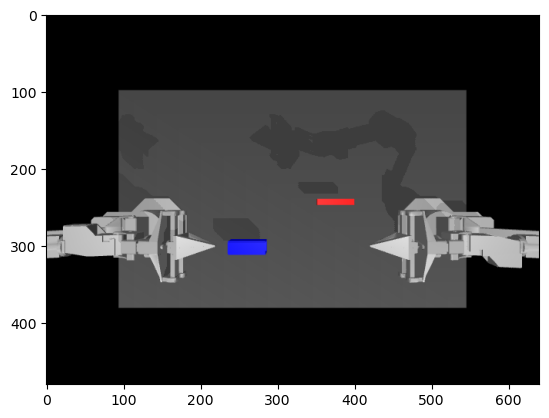

In [6]:
plt.imshow(observation['top'])

In [7]:

for _ in range(100):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    image = env.render()
    frames.append(image)

    if terminated or truncated:
        observation, info = env.reset()

env.close()
imageio.mimsave("example.mp4", np.stack(frames), fps=25)

In [6]:
def find_available_ports():
    if os.name == "nt":  # Windows
        # List COM ports using pyserial
        ports = [port.device for port in list_ports.comports()]
    else:  # Linux/macOS
        # List /dev/tty* ports for Unix-based systems
        ports = [str(path) for path in Path("/dev").glob("tty*")]
    return ports

find_available_ports()[-5:]

['/dev/tty.Bluetooth-Incoming-Port',
 '/dev/ttys001',
 '/dev/ttys002',
 '/dev/ttys003',
 '/dev/ttys000']

In [69]:
from lerobot.common.robot_devices.control_configs import (
    ControlPipelineConfig,
    TeleoperateControlConfig
)
from lerobot.configs import parser
import sys
import draccus

# Simulate command line arguments
sys.argv = [
    "control_robot.py",  # First argument is always the script name
    "--robot.type=so100",
    "--robot.cameras={}",
    "--control.type=teleoperate"
]

In [10]:
arg2 = [
    "control_robot.py", 
    "--robot.type=so100" ,
  "--control.type=record" ,
  "--control.fps=30" ,
  "--control.single_task='Grasp a lego block and put it in the bin.'" ,
  "--control.repo_id=${HF_USER}/so100_test" ,
  "--control.warmup_time_s=5" ,
  "--control.episode_time_s=30" ,
  "--control.reset_time_s=30" ,
  "--control.num_episodes=2",
  "--control.push_to_hub=true"   
]

In [11]:
cfg = draccus.parse(config_class=ControlPipelineConfig, args=arg2[1:])

In [12]:
cfg.robot

So100RobotConfig(leader_arms={'main': FeetechMotorsBusConfig(port='/dev/tty.usbmodem58FA1015181', motors={'shoulder_pan': [1, 'sts3215'], 'shoulder_lift': [2, 'sts3215'], 'elbow_flex': [3, 'sts3215'], 'wrist_flex': [4, 'sts3215'], 'wrist_roll': [5, 'sts3215'], 'gripper': [6, 'sts3215']}, mock=False)}, follower_arms={'main': FeetechMotorsBusConfig(port='/dev/tty.usbmodem58FA0919571', motors={'shoulder_pan': [1, 'sts3215'], 'shoulder_lift': [2, 'sts3215'], 'elbow_flex': [3, 'sts3215'], 'wrist_flex': [4, 'sts3215'], 'wrist_roll': [5, 'sts3215'], 'gripper': [6, 'sts3215']}, mock=False)}, cameras={'laptop': OpenCVCameraConfig(camera_index=0, fps=30, width=640, height=480, color_mode='rgb', channels=3, rotation=None, mock=False), 'phone': OpenCVCameraConfig(camera_index=1, fps=30, width=640, height=480, color_mode='rgb', channels=3, rotation=None, mock=False)}, max_relative_target=None, gripper_open_degree=None, mock=False, calibration_dir='/Users/samart/Documents/Robotics/lerobot/lerobot-ha

In [13]:
robot = make_robot_from_config(cfg.robot)

In [14]:
#if not robot.is_connected:
robot.connect()

Connecting main follower arm.

Try running `python lerobot/scripts/find_motors_bus_port.py` to make sure you are using the correct port.



Traceback (most recent call last):
  File "/Users/samart/miniforge3/envs/lerobot/lib/python3.10/site-packages/serial/serialposix.py", line 322, in open
    self.fd = os.open(self.portstr, os.O_RDWR | os.O_NOCTTY | os.O_NONBLOCK)
FileNotFoundError: [Errno 2] No such file or directory: '/dev/tty.usbmodem58FA0919571'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/samart/Documents/Robotics/lerobot/lerobot-hackathon/lerobot/common/robot_devices/motors/feetech.py", line 324, in connect
    if not self.port_handler.openPort():
  File "/Users/samart/miniforge3/envs/lerobot/lib/python3.10/site-packages/scservo_sdk/port_handler.py", line 25, in openPort
    return self.setBaudRate(self.baudrate)
  File "/Users/samart/miniforge3/envs/lerobot/lib/python3.10/site-packages/scservo_sdk/port_handler.py", line 49, in setBaudRate
    return self.setupPort(baud)
  File "/Users/samart/miniforge3/envs/lerobot/lib/python3.10/site-packa

SerialException: [Errno 2] could not open port /dev/tty.usbmodem58FA0919571: [Errno 2] No such file or directory: '/dev/tty.usbmodem58FA0919571'

In [74]:
robot.capture_observation()

{'observation.state': tensor([  -5.8887, -183.1641,  159.6973,   88.5938,   -2.3730,   -0.2174])}

In [75]:
type(robot)

lerobot.common.robot_devices.robots.manipulator.ManipulatorRobot

In [61]:
_init_rerun(control_config=cfg.control, session_name="lerobot_control_loop_record")

In [60]:
from lerobot.scripts.control_robot import *